In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp '/content/drive/My Drive/SKU110K_fixed.tar.gz' '/content/sku100k.tar.gz'

cp: cannot stat '/content/drive/My Drive/SKU110K_fixed.tar.gz': No such file or directory


In [0]:
import tarfile
with tarfile.open('/content/drive/My Drive/sku100k.tar.gz') as tar:
    tar.extractall()

OSError: ignored

In [0]:
import os
len(os.listdir('/content/SKU110K/images'))

4369

## Importing Libraries


In [0]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
import re

## Train and Test Data Path


### Pre Processing image and label

In [0]:
hImage,wImage=512,512
nClasses=1

def pre_process_data(path):
  colnames=['Img','x','y','w','h',\
            'class','ImgW','ImgH']
  
  annotate_data=pd.read_csv(path)
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(annotate_data['class'])
  idx=tokenizer.word_index

  annotate_data = annotate_data.astype({"x1": float,\
                                        "x2": float,\
                                        "y1": float,\
                                        "y2": float})

  #Resize bb according to image
  annotate_data.iloc[:,1]=(annotate_data.iloc\
                           [:,1]*wImage)/annotate_data.iloc[:,6]
  annotate_data.iloc[:,2]=(annotate_data.iloc\
                           [:,2]*hImage)/annotate_data.iloc[:,7]
  annotate_data.iloc[:,3]=(annotate_data.iloc\
                           [:,3]*wImage)/annotate_data.iloc[:,6]
  annotate_data.iloc[:,4]=(annotate_data.iloc\
                           [:,4]*hImage)/annotate_data.iloc[:,7]
  
  annotate_data.iloc[:,5]=idx['object']
  annotate_data['boxes_x1y1x2y2']=annotate_data\
  [['x1','y1','x2','y2','class']].to_numpy().tolist()

  #Converting to x,y,w,h
  annotate_data.iloc[:,1]=(annotate_data.iloc\
                           [:,1]+annotate_data.iloc[:,3])/2.0
  annotate_data.iloc[:,2]=(annotate_data.iloc\
                           [:,2]+annotate_data.iloc[:,4])/2.0
  annotate_data.iloc[:,3]=(annotate_data.iloc\
                           [:,3]-annotate_data.iloc[:,1])
  annotate_data.iloc[:,4]=(annotate_data.iloc\
                           [:,4]-annotate_data.iloc[:,2])
  annotate_data['boxes_xywh']=annotate_data\
  [['x1','y1','x2','y2','class']].to_numpy().tolist()
  annotate_data = annotate_data.groupby('image_name').\
  aggregate(lambda tdf: tdf.tolist())
  return annotate_data

path='/content/SKU110K/annotations/annotations_val.csv'
annotate_data=pre_process_data(path)


In [0]:
def read_img(img):
  with tf.io.gfile.GFile(img, 'rb') as fp:
    image = fp.read()

    
  return image

In [0]:
annotate_data=annotate_data[:10]

NameError: ignored

In [0]:
def wrap_bytes(img):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[img]))

def wrap_float(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

out_path='/content/val.tfrecords'
def convert_tfrecord(images,labels,out_path):
  root='/content/SKU110K/images'
  with tf.io.TFRecordWriter(out_path) as writer:
    for i in range(len(images)):
      print(type(images))
      print(type(labels))
      label_0=[]
      for i in np.array(labels[i])[:,0]:
        label_0.append(i)
      print(label_0)
      image=os.path.join(root,images[i])
      img_bytes=read_img(image)
      sku={
            'image':wrap_bytes(img_bytes),
            'x':wrap_float(label_0),
            'y':wrap_float(np.array(labels)[:,1]),
            'w':wrap_float(np.array(labels)[:,2]),
            'h':wrap_float(np.array(labels)[:,3]),
            'class':wrap_float(np.array(labels)[:,4])
      }
      feature=tf.train.Features(feature=sku)
      example=tf.train.Example(features=feature)
      serialized=example.SerializeToString()
      writer.write(serialized)
convert_tfrecord(annotate_data.index,annotate_data['boxes_xywh'],out_path)


<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.series.Series'>
[24.54794520547945, 115.72602739726028, 146.95890410958904, 180.82191780821918, 212.71232876712327, 245.91780821917808, 278.02739726027403, 309.04109589041093, 340.05479452054794, 371.3972602739726, 402.95890410958907, 433.31506849315065, 463.7808219178082, 495.3424657534247, 494.9041095890411, 468.4931506849315, 80.0, 44.82191780821918, 30.575342465753423, 13.917808219178083, 458.5205479452055, 488.0, 485.47945205479454, 454.24657534246575, 423.67123287671234, 393.972602739726, 360.54794520547944, 440.986301369863, 326.027397260274, 267.94520547945206, 239.78082191780823, 209.75342465753425, 179.2876712328767, 145.3150684931507, 113.86301369863014, 80.0, 295.1232876712329, 415.67123287671234, 387.5068493150685, 358.79452054794524, 223.23287671232876, 249.0958904109589, 277.5890410958904, 277.3698630136986, 281.75342465753425, 270.13698630136986, 259.83561643835617, 196.16438356164383, 308.6027397260274, 343.5

IndexError: ignored

In [0]:
i1xywh
i1xywh
i1xywh


In [0]:
a=[[1,5],[2,3]]
np.array(a)[:,0]

array([1, 2])

In [0]:
def convert_back(serialized):  
  feature={
      'image':tf.io.FixedLenFeature([],tf.string),
      'x':tf.io.VarLenFeature(tf.float32),
      'y':tf.io.VarLenFeature(tf.float32),
      'w':tf.io.VarLenFeature(tf.float32),
      'h':tf.io.VarLenFeature(tf.float32),
      'class':tf.io.VarLenFeature(tf.float32)
  }
  parsed_example = tf.io.parse_single_example(serialized=serialized,
                                            features=feature)
  img = tf.io.decode_image(parsed_example['image'],channels=3)

  label=tf.stack([tf.sparse.to_dense(parsed_example['x']),
            tf.sparse.to_dense(parsed_example['y']),
            tf.sparse.to_dense(parsed_example['w']),
            tf.sparse.to_dense(parsed_example['h']),
            tf.sparse.to_dense(parsed_example['class'])],axis=-1)
  return img, label

In [0]:
batch_size=25
epochs=5
files='/content/val.tfrecords'
dataset=tf.data.TFRecordDataset(filenames=files)
dataset = dataset.map(convert_back)
for i,l in dataset.take(1):
  i=tf.image.resize(i,[512,512])
  print(i,l)


tf.Tensor(
[[[ 72.15234   75.15234   56.152344]
  [ 80.96875   79.96875   61.96875 ]
  [ 80.072266  77.072266  60.072266]
  ...
  [ 81.21875   89.21875   76.21875 ]
  [ 82.66992   90.66992   77.66992 ]
  [ 79.87695   87.87695   74.87695 ]]

 [[ 70.38086   73.38086   54.38086 ]
  [ 74.3125    73.3125    55.3125  ]
  [ 76.9082    73.9082    56.908203]
  ...
  [ 74.34375   82.34375   69.34375 ]
  [ 76.6875    84.6875    71.6875  ]
  [ 82.5       90.5       77.5     ]]

 [[ 69.03125   70.03125   54.03125 ]
  [ 72.4082    73.4082    57.408203]
  [ 69.80859   70.80859   54.808594]
  ...
  [ 78.56641   86.56641   75.56641 ]
  [ 80.875     88.875     77.875   ]
  [ 73.28125   81.28125   70.28125 ]]

 ...

 [[136.97852  136.97852  128.97852 ]
  [142.6543   142.6543   134.6543  ]
  [134.71875  134.71875  126.71875 ]
  ...
  [157.86523  158.86523  150.86523 ]
  [153.15625  154.15625  146.15625 ]
  [150.04102  151.04102  143.04102 ]]

 [[141.30078  138.30078  131.30078 ]
  [139.92383  136.92383  1

In [0]:
batch_size=64
epochs=5
def data_gen(files):
  dataset=tf.data.TFRecordDataset(filenames=files)
  dataset = dataset.map(convert_back)
  dataset = dataset.shuffle(10000)
  dataset = dataset.batch(batch_size)
  dataset = dataset.repeat(epochs)
  return dataset
files='/content/test.tfrecords'

#### Convert ground truth x,y,w,h to x1,y1,x2,y2

In [0]:
def convert_format(out,format):
  if format=='x1y1x2y2':
    return np.stack([out[...,0]-out[...,2]/2.0,
    out[...,0]+out[...,2]/2.0,
    out[...,1]-out[...,3]/2.0,
    out[...,1]+out[...,3]/2.0],axis=1)
  if format=='xywh':
    return np.stack([(out[...,0]+out[...,2])/2.0,
    (out[...,1]+out[...,3])/2.0,
    out[...,2]-out[...,0],
    out[...,3]+out[...,1]],axis=1)

In [0]:
#Show img
def show_img(img,label):
  img=cv2.imread(img)
  color=(255,0,0)
  img=cv2.resize(img,(hImage,wImage))
  for i,val in enumerate(label):
    start=tuple(np.array(label[i][:2]).astype('int'))
    end=tuple(np.array(label[i][2:4]).astype('int'))
    font = cv2.FONT_HERSHEY_SIMPLEX  
    fontScale = 1
    color = (255, 0, 0) 
    thickness = 2
    cv2.rectangle(img,start,end,color,2)
  cv2_imshow(img)
img='/content/SKU110K_fixed/images/test_1.jpg'
label=annotate_data.loc['test_1.jpg']['boxes_x1y1x2y2']
show_img(img,label)

In [0]:
data_kmeans=annotate_data[['w','h']]
data_kmeans['w_relative']=data_kmeans[['w']]/wImage
data_kmeans['h_relative']=data_kmeans[['h']]/hImage
data_kmeans['wh']=data_kmeans[["w_relative", "h_relative"]].max(axis=1)
#data_kmeans['wh'] = data_kmeans.max_w * data_kmeans.max_h
data_kmeans['wh_sqrt']=np.sqrt(data_kmeans['wh'])

model = KMeans(
    n_clusters=7, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0)
y_km = model.fit(data_kmeans[['wh_sqrt']])

centroids = model.cluster_centers_
print(centroids)


NameError: ignored

### Creating default boxes

In [0]:
def create_df_box(feature_layers):
  '''
  #CREATING SCALE
  #Scale of default boxes for each feature layer are computed by 
  #s_min+(s_max-s_min)/(m-1)*(k-1)
  s_min=0.03
  s_max=0.32
  #No. of feature layer
  m=6
  scale=[]

  #Range starting from 2 because we are starting from feature layer 2
  for k in range(2,6):
    sk=s_min+(s_max-s_min)/(m-1)*(k-1)
    scale.append(sk)
  scale.insert(0,s_min)
  scale.extend([s_max])
  '''
  scale = [0.03, 0.05, 0.08, 0.12, 0.15, 0.25, 0.35]
  aspect_ratios= [0.416, 0.553, 0.722, 1.401, 3.131]
  feature_boxes=[]
  for feature_layer in feature_layers:
    #Computing w and h
    '''
    if feature_layer==38 or feature_layer==3\
     or feature_layer==1:
      aspect_ratios=[1,2,1/2]
    else:
      aspect_ratios=[1,2,3,1/2,1/3]
    '''
    w_ar=[]
    h_ar=[]
    for i in aspect_ratios:
      if i==1:
        w=scale[aspect_ratios.index(i)]*np.sqrt(i)
        h=scale[aspect_ratios.index(i)]/np.sqrt(i)
        w_ar.append(w)
        h_ar.append(h)
        sk_1=np.sqrt(scale[aspect_ratios.index(i)]* \
                     scale[aspect_ratios.index(i)+1])
        w=sk_1*np.sqrt(i)
        h=sk_1/np.sqrt(i)
      else:
        w=scale[aspect_ratios.index(i)]*np.sqrt(i)
        h=scale[aspect_ratios.index(i)]/np.sqrt(i)
      w_ar.append(w)
      h_ar.append(h)
    #Computing x and y    
    x_axis=np.linspace(0,feature_layer,feature_layer+1)
    y_axis=np.linspace(0,feature_layer,feature_layer+1)
    xx,yy=np.meshgrid(x_axis,y_axis)
    x=[(i+0.5)/(feature_layer) for i in xx[:-1,:-1]]
    y=[(i+0.5)/(feature_layer) for i in yy[:-1,:-1]]
    '''
    if feature_layer==38 or feature_layer==3 or\
     feature_layer==1:
      ndf_box=4
    else:
      ndf_box=6
    '''
    ndf_box=5
    ndf_boxes=feature_layer*feature_layer*ndf_box
    nbox_coordinates=4
    feature_box=np.zeros((ndf_boxes,nbox_coordinates))
    #x would be 38*38 center for every df box
    x=np.array(x).reshape(feature_layer*feature_layer)
    #We have the same center for 4 default boxes 
    x=np.repeat(x,ndf_box)
    y=np.array(y).reshape(feature_layer*feature_layer)
    y=np.repeat(y,ndf_box)

    #W would be 4*1 or 6*1 based on aspect ratio   
    w_ar=np.tile(w_ar,feature_layer*feature_layer)
    h_ar=np.tile(h_ar,feature_layer*feature_layer)
    feature_box[:,0]=x
    feature_box[:,1]=y
    feature_box[:,2]=w_ar
    feature_box[:,3]=h_ar
    feature_boxes.append(feature_box)
  feature_box=np.concatenate([i for i in feature_boxes],axis=0)
  return feature_box

In [0]:
feature_layers=[64,32,16,8,6,4]
feature_layers=create_df_box(feature_layers)
feature_layers.shape

NameError: ignored

#### Converting Relative co-ordinates to absolute co-ordinates 

In [0]:
def rel_to_abs(matrix):
  return np.stack([matrix[:,0]*wImage,
  matrix[:,1]*hImage,
  matrix[:,2]*wImage,
  matrix[:,3]*hImage],axis=1)
label1=rel_to_abs(np.array(label))

NameError: ignored

#### IOU b/w two boxes

In [0]:
def iou(box1,box2):
  x1=np.maximum(box1[...,0],box2[...,0])
  y1=np.maximum(box1[...,1],box2[...,1])
  x2=np.minimum(box1[...,2],box2[...,2])
  y2=np.minimum(box1[...,3],box2[...,3])
  #Intersection area
  intersectionArea=(x2[:]-x1[:])*(y2[:]-y1[:])
  
  #Union area
  box1Area=(box1[...,2]-box1[...,0])*\
  (box1[...,3]-box1[...,1])
  box2Area=(box2[...,2]-box2[...,0])*\
  (box2[...,3]-box2[...,1])
  unionArea=box1Area+box2Area-intersectionArea
  iou=intersectionArea/unionArea
  return iou


In [0]:
feature_layers=[64,32,16,8,6,4]
feature_box=create_df_box(feature_layers)
feature_box=rel_to_abs(feature_box)
feature_box_conv=convert_format(feature_box\
                                ,'x1y1x2y2')
gt_box_conv=convert_format(np.array(label)\
                           ,'x1y1x2y2')
iou_matrix=iou(np.expand_dims(feature_box_conv,axis=1),gt_box_conv)

### Matching statergy


In [0]:
def df_match(labels,iou_matrix):
  #No. of ground truth labels
  max_values=np.max(iou_matrix,axis=1)
  max_idx=np.argmax(iou_matrix,axis=1)
  matched=np.greater_equal(max_values,0.5)
  gt_box=tf.gather(np.array(labels)[...,:4],max_idx)
  return gt_box,matched
gt_box,matched=df_match\
(np.array(label),iou_matrix)

In [0]:
gt_box.shape

TensorShape([27460, 4])

In [0]:
nClasses=1
#Class encoding matched with default boxes
def class_df_encode(out,iou_matrix):
  max_values=np.max(iou_matrix,axis=1)
  max_idx=np.argmax(iou_matrix,axis=1)  
  #0 For Background class 
  matched=np.greater_equal(max_values,0.5)
  cls_df=tf.gather(np.array(out)[:,4:],max_idx)
  cls=np.array(matched*cls_df)  
  dfclass=(tf.one_hot(cls[:,nClasses],depth=nClasses+1))
  return dfclass

In [0]:
dfclass=class_df_encode(np.array(label),iou_matrix)
dfclass.shape

TensorShape([27460, 2])

### Matched Boxes 

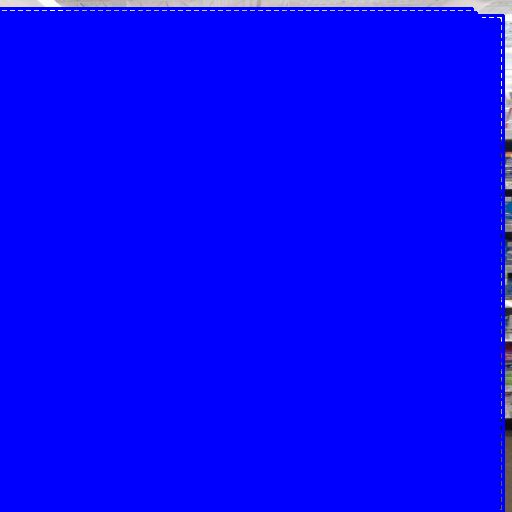

In [0]:
wImage,hImage=512,512
#Here x1,y1,x2,y2
def pre_process_img(img,df_matrix,matched):
  img=cv2.imread(img)
  img = cv2.resize(img, (hImage,wImage), \
                   interpolation = cv2.INTER_AREA)
  color=(255,0,0)
  matched_idx=[i for i,val in \
               enumerate(matched) if val]
  for i in (matched_idx):
    start=feature_box_conv[i,:2]
    start=start.astype('int')
    end=feature_box_conv[i,2:]
    end=end.astype('int')
    start=tuple((start))
    end=tuple((end))
    cv2.rectangle(img,start,end,color,2)
  cv2_imshow(img)
  
pre_process_img('/content/SKU110K_fixed/images/test_1.jpg',feature_box,matched)

### Normalizing Ground Truth

In [0]:
def normalised_gt(matched_boxes,feature_box):
  return np.stack([
  (matched_boxes[:,0]-feature_box[:,0])/feature_box[:,0],
  (matched_boxes[:,1]-feature_box[:,1])/feature_box[:,1],
  np.log(matched_boxes[:,2]/feature_box[:,2]),
  np.log(matched_boxes[:,3]/feature_box[:,3])],axis=-1)


In [0]:
#Data Generator
batch_size=1
epochs=1
feature_layers=[64,32,16,8,6,4]
feature_box=create_df_box(feature_layers)
feature_box=rel_to_abs(feature_box)
feature_box_conv=np.zeros_like(feature_box)
feature_box_conv=convert_format(np.array(feature_box),'x1y1x2y2')

def dataGen(annotate_data,batchSize,epochs,feature_box,feature_box_conv):
  for j in range(0,epochs):
    for k in range(0, len(annotate_data)//batchSize):
      batchX=[]
      batchY=[]
      index=np.random.randint(0,len(annotate_data),batchSize)
      for i in index:
        img_path='/content/SKU110K_fixed/images/'
        img=img_path+str(annotate_data.iloc[i].name)
        label=annotate_data.iloc[i]['boxes_xywh']
        img=read_img(img)
        gt_box_conv=convert_format(np.array(label)[:,:4],'x1y1x2y2')
        iou_matrix=iou(np.expand_dims(feature_box_conv,axis=1),(gt_box_conv))
        max_idx,matched=df_match(label,iou_matrix)
        dfclass=class_df_encode(label,iou_matrix)
        normalised_gtbox=normalised_gt(gt_box,feature_box)
        normalised_gtbox_abs=rel_to_abs(normalised_gtbox)
        df_box=np.concatenate((normalised_gtbox_abs,dfclass),axis=1)
        batchX.append(img)
        batchY.append(df_box)
      yield np.array(batchX),np.array(batchY)
trainGen=dataGen(annotate_data,batch_size,epochs,feature_box,feature_box_conv)

In [0]:
img_list=[]
for i in os.listdir('/content/SKU110K_fixed/images'):
  img_list.append(i)
b=set(annotate_data.index)-set(img_list)
annotate_data.drop(b,inplace=True)


### Loss

In [0]:
def total_loss(y_true,y_pred):
  y_true=tf.cast(y_true,dtype=tf.float32)
  y_pred=tf.cast(y_pred,dtype=tf.float32)
  pos_mask=tf.equal(y_true[:,:,-4:-3],0.0)
  num_pos=tf.math.count_nonzero(pos_mask)
  loc_loss=(tf.compat.v1.losses.huber_loss
            (y_true[:,:,:4], y_pred[:,:,:4]))
  cce = tf.losses.CategoricalCrossentropy()
  cross_entropy=cce(y_true[:,:,-4:],y_pred[:,:,-4:])
  #neg:pos 3:1
  num_neg=3*num_pos
  #Negative Mining
  neg_cross_entropy=tf.where(tf.not_equal\
                             (pos_mask,1.0),cross_entropy,0.0)
  sorted_dfidx=tf.argsort(neg_cross_entropy,\
                          direction='DESCENDING',axis=1)
  rank=tf.argsort(sorted_dfidx,axis=1)
  neg_loss=tf.where((rank)<num_neg,neg_cross_entropy,0.0)
  pos_loss=tf.where(tf.equal(pos_mask,1.0),cross_entropy,0.0)
  pos_loss=tf.reduce_sum(pos_loss,axis=1)
  clas_loss=tf.reduce_sum(pos_loss+neg_loss)
  totalloss=tf.math.divide_no_nan(
    (loc_loss+clas_loss),num_pos , name='Total_loss')
  return totalloss


In [0]:
nClasses=1
import tensorflow as tf
def conv_layer(filter,kernel_size,
               layer,strides=1,
               padding='same',
               activation='relu',pool=False,
               poolsize=2,poolstride=2,conv=True):
  if conv == True:
      layer=tf.keras.layers.Conv2D(filters=filter,
                                  kernel_size=kernel_size,
                                  strides=strides,
                                  activation=activation,
                                  padding=padding)(layer)
  if pool == True:
    layer=tf.keras.layers.MaxPool2D(pool_size=(poolsize,poolsize),
                                    strides=poolstride,padding='same')(layer)
  return layer


inputs=tf.keras.layers.Input(shape=(512,512,3))

#vgg16 was trained on 224,224,3 size images, so creating it for 300,300,3
#In pool 5 we pass stride = 1 and pool size =2
#No dropout used
outputs=[]

#Feature layer 1 - 38*38*512
layer = conv_layer(64, 3, inputs)
layer = conv_layer(64, 3, layer,pool=True)
layer = conv_layer(128, 3, layer)
layer = conv_layer(128, 3, layer, pool=True)
layer = conv_layer(256, 3, layer)
layer = conv_layer(256, 3, layer)
layer = conv_layer(256, 3, layer, pool=True)
layer = conv_layer(512, 3, layer)
layer = conv_layer(512, 3, layer)
layer = conv_layer(512, 3, layer)

output=conv_layer(4*(4+nClasses+1),3,layer)
print(output)
output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
outputs.append(output)

#Feature layer 2 19*19*1024
layer = conv_layer(512, 3, layer,pool=True,conv=False)
layer = conv_layer(512, 3, layer)
layer = conv_layer(512, 3, layer)
layer = conv_layer(512, 3 , layer,pool=True, poolsize=3, poolstride=1)
layer = conv_layer(1024, 3, layer)
layer = conv_layer(1024, 1, layer)

output=conv_layer(6*(4+nClasses+1),3,layer)
print(output)
output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
outputs.append(output)

#Extra Feature Layers

#Feature Layer 3 10*10*512
layer = conv_layer(256, 1, layer)
layer = conv_layer(512, 3, layer, strides=2)
output=conv_layer(6*(4+nClasses+1),3,layer)
print(output)
output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
outputs.append(output)

#Feature Layer 4 5*5*256
layer = conv_layer(128, 1, layer)
layer = conv_layer(256, 3, layer, strides=2)
output=conv_layer(6*(4+nClasses+1),3,layer)
print(output)
output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
outputs.append(output)

#Feature Layer 4 3*3*256
layer = conv_layer(128, 1, layer,padding= 'valid')
layer = conv_layer(256, 3, layer,padding= 'valid')
output=conv_layer(4*(4+nClasses+1),3,layer)
print(output)
output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
outputs.append(output)

#Feature Layer 4 1*1*256
layer = conv_layer(128, 1, layer,padding= 'valid')
layer = conv_layer(256, 3, layer,padding= 'valid')
output=conv_layer(4*(4+nClasses+1),3,layer)
print(output)
output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
outputs.append(output)

out = tf.keras.layers.Concatenate(axis=1)(outputs)
model=tf.keras.models.Model(inputs,out)

model.summary()


Tensor("conv2d_97/Identity:0", shape=(None, 64, 64, 24), dtype=float32)
Tensor("conv2d_103/Identity:0", shape=(None, 32, 32, 36), dtype=float32)
Tensor("conv2d_106/Identity:0", shape=(None, 16, 16, 36), dtype=float32)
Tensor("conv2d_109/Identity:0", shape=(None, 8, 8, 36), dtype=float32)
Tensor("conv2d_112/Identity:0", shape=(None, 6, 6, 24), dtype=float32)
Tensor("conv2d_115/Identity:0", shape=(None, 4, 4, 24), dtype=float32)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, 512, 512, 64) 1792        input_4[0][0]                    
_________________________________________________________

In [0]:
model.compile(optimizer='adam',metrics=['accuracy'],
              loss=total_loss)
callback=tf.keras.callbacks.ModelCheckpoint(
        filepath=
        'content/ssd_weights.h5',
        monitor='total_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=1)
step_per_epoch=len(annotate_data)//batch_size
model.fit_generator(trainGen,epochs,step_per_epoch,callbacks=callback)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/1493


TypeError: ignored

In [0]:
img,label=pre_process_data(trainImagePath[50],trainAnnotationPath[50])
y_pred=model.predict(img)
tf.image.non_max_suppression(
    boxes, scores, max_output_size, iou_threshold=0.5,
    score_threshold=float('-inf'), name=None
)
